In [1]:
"""
In this nb, we are forecasting Time-Series with a Stateful Recurrent Neural Network(RNN) Model unlike
previously where we used Stateless RNN. In Stateful RNN, we pass state of previous Batch to the next batch but 
in Stateless, we passed 0 instead. After Every Epoch, we have to reset the state of final batch.
"""

# Importing stuff
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
keras = tf.keras

# A function to plot time-series. This will be called finally when complete series is built
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end],series[start:end],format,label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
# Function to create a trend
def trend(time,slope=0):
    return slope*time

# Creating a time series
time = np.arange(4*365+1)
baseline = 10 #Base value for trend 

# Function which creates a random pattern. This pattern will be repeated to get a seasonal pattern
def seasonal_pattern(seasonal_time):
    return np.where(seasonal_time < 0.4,
                    1/np.exp(3*seasonal_time),
                    np.cos(seasonal_time*2*np.pi))

# Function to repeat seasonal pattern
def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase) % period)/period
    return amplitude * seasonal_pattern(season_time)

# Function to create white noise. seed parameter here is used by random number generator as a base to create
# random number. When it is None, rnd will use system time as seed. But, if we give some constant value like 42,
# then every time same noise will be generated. Thus, to get different noise everytime keep seed as None even 
# while calling the function
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Creating Seasonality 
amplitude = 50
series = seasonality(time,period=365,amplitude=amplitude) + baseline

# Creating White Noise
noise_level = 5
noise = white_noise(time,noise_level)

# Creating seasonality with trend
slope = 0.05
series = baseline + trend(time,slope) + seasonality(time,period=365,amplitude=amplitude)

# Finally plotting complete time-series
series += noise
plt.figure(figsize=(10,10))
plot_series(time,series,label="Time-Series")

# Creating Training and Validation data
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Function to apply our model to series(This will be validation series)
def model_forecast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
# No Shuffling of data- Continuous data is needed
# Shifting by window_size
# Batch contains only single window, training becomes slow
def sequential_window_dataset(series,window_size,batch_size=32):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1],window[-1:]))
    dataset = dataset.batch(1).prefetch(1)
    return dataset

In [6]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

Epoch 1/100
33/33 [==============================] - 4s 115ms/step - loss: 105.7181 - mae: 106.2179
Epoch 2/100
33/33 [==============================] - 1s 25ms/step - loss: 74.1496 - mae: 73.9117
Epoch 3/100
33/33 [==============================] - 1s 23ms/step - loss: 54.0279 - mae: 53.6682
Epoch 4/100
33/33 [==============================] - 1s 28ms/step - loss: 45.2692 - mae: 44.9059
Epoch 5/100
33/33 [==============================] - 1s 24ms/step - loss: 41.4726 - mae: 41.1659
Epoch 6/100
33/33 [==============================] - 1s 25ms/step - loss: 38.9883 - mae: 38.7463
Epoch 7/100
33/33 [==============================] - 1s 36ms/step - loss: 36.6731 - mae: 36.4953
Epoch 8/100
33/33 [==============================] - 1s 35ms/step - loss: 34.4102 - mae: 34.2897
Epoch 9/100
33/33 [==============================] - 1s 32ms/step - loss: 32.0716 - mae: 32.0313
Epoch 10/100
33/33 [==============================] - 1s 28ms/step - loss: 30.0973 - mae: 30.1428
Epoch 11/100
33/33 [======

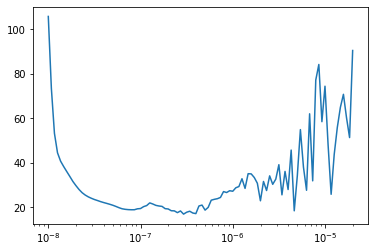

In [7]:
# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = sequential_window_dataset(x_train,window_size)

# Simple RNN Model, return_sequences=True makes first Recurrent layer to return output for each time-stamp
# Recurrent layers need 3-d input_shape, [batch_size, number of time stamps, dimensionality of input]
# tf.expand_dims add one more dimension of 1 since we are using uni-variate time series.
# This is required because window_dataset creates 2-d dataset
# stateful = True makes sure that the state of previous batch goes to the next one
model = tf.keras.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0) #The output of RNN layers is normalised between [-1,1]
])

# We can use Learning Rate Scheduler which can show us at which lr model is giving better results
# After every 30 epochs lr is * by 10 power and model is evaluated using it
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/30))
reset_state = ResetStatesCallback()

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,callbacks=[lr_schedule,reset_state])

plt.semilogx(history.history['lr'],history.history['loss'])

In [8]:
# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = sequential_window_dataset(x_train,window_size)
valid_set = sequential_window_dataset(x_valid,window_size)

# Simple RNN Model, return_sequences=True makes first Recurrent layer to return output for each time-stamp
# Recurrent layers need 3-d input_shape, [batch_size, number of time stamps, dimensionality of input]
# tf.expand_dims add one more dimension of 1 since we are using uni-variate time series.
# This is required because window_dataset creates 2-d dataset
# stateful = True makes sure that the state of previous batch goes to the next one
model = tf.keras.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0) #The output of RNN layers is normalised between [-1,1]
])

# Stops training if metric stays same for 50 epochs on valid_set
early_stopper = keras.callbacks.EarlyStopping(patience=50)
reset_state = ResetStatesCallback()

# Saves the best model(model with best parameters) as "my_checkpoint.h5" so that we can load this model at end
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only = True)

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[early_stopper,reset_state])

plt.semilogx(history.history['lr'],history.history['loss'])

Epoch 1/100
33/33 [==============================] - 4s 135ms/step - loss: 76.6628 - mae: 77.1616 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
33/33 [==============================] - 1s 28ms/step - loss: 31.5438 - mae: 33.3770 - val_loss: 18.9731 - val_mae: 19.4676
Epoch 3/100
33/33 [==============================] - 1s 27ms/step - loss: 28.6526 - mae: 28.6560 - val_loss: 14.8925 - val_mae: 15.3868
Epoch 4/100
33/33 [==============================] - 1s 28ms/step - loss: 23.9971 - mae: 24.4541 - val_loss: 15.8539 - val_mae: 16.3476
Epoch 5/100
33/33 [==============================] - 1s 28ms/step - loss: 21.6640 - mae: 22.6434 - val_loss: 14.8652 - val_mae: 15.3610
Epoch 6/100
33/33 [==============================] - 1s 28ms/step - loss: 20.9038 - mae: 21.8323 - val_loss: 15.1932 - val_mae: 15.6878
Epoch 7/100
33/33 [==============================] - 1s 30ms/step - loss: 20.0267 - mae: 21.0962 - val_loss: 14.3763 - val_mae: 14.8677
Epoch 8/100
33/33 [======================

Epoch 61/100
33/33 [==============================] - 1s 26ms/step - loss: 14.1166 - mae: 14.1091 - val_loss: 14.7817 - val_mae: 15.2742
Epoch 62/100
33/33 [==============================] - 1s 25ms/step - loss: 14.0457 - mae: 14.0421 - val_loss: 14.7867 - val_mae: 15.2786
Epoch 63/100
33/33 [==============================] - 1s 27ms/step - loss: 13.9627 - mae: 13.9677 - val_loss: 14.7865 - val_mae: 15.2780
Epoch 64/100
33/33 [==============================] - 1s 28ms/step - loss: 13.8840 - mae: 13.8959 - val_loss: 14.8090 - val_mae: 15.3011
Epoch 65/100
33/33 [==============================] - 1s 26ms/step - loss: 13.8034 - mae: 13.8239 - val_loss: 14.8284 - val_mae: 15.3206
Epoch 66/100
33/33 [==============================] - 1s 27ms/step - loss: 13.7414 - mae: 13.7634 - val_loss: 14.8711 - val_mae: 15.3633
Epoch 67/100
33/33 [==============================] - 1s 27ms/step - loss: 13.6812 - mae: 13.7049 - val_loss: 14.9019 - val_mae: 15.3943
Epoch 68/100
33/33 [=====================

KeyError: 'lr'

In [10]:
model = keras.models.load_model("my_checkpoint.h5")

In [11]:
model.reset_states()
# We're forecasting on complete series and then cropping out only the validation part for plotting
rnn_forecast = model.predict(series[np.newaxis,:,np.newaxis])[0,split_time-1:-1,0]

5.0483117

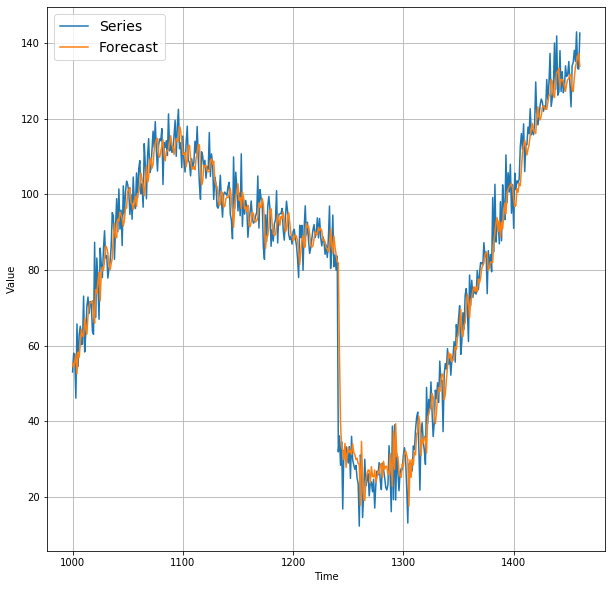

In [12]:
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,rnn_forecast,label="Forecast")

keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()
# MAE is still 5.04